In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
pybn_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/pyBN-master'
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
if pybn_dir not in sys.path:
    sys.path.append(pybn_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise
from latent_nce_optimiser import LatentNCEOptimiser, CDOptimiser
from latent_variable_model import RestrictedBoltzmannMachine

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

# Experimental setup

In [3]:
n = 10000 # number of datapoints
nz = 1  # number latent samples per datapoint
nu = 1  # ratio of noise to data samples for NCE
num_gibbs_steps_for_synthetic_data = 200
d = 50  # visible dimension
m = 5  # latent dimension
true_W = np.zeros((d+1, m+1))
for i in range(m + 1):
    true_W[:, i] = rnd.uniform(-1/(i+1), 1/(i+1), d+1)  # true setting of the weights, that we are trying to learn
theta0 = rnd.randn(d+1, m+1)*0.01  # random initialisation of weights
#theta0 = true_W

#### Optimisation hyperparameters

In [4]:
# tolerances used to determine when iterations stop in scipy minimize (used in LatentNCEOptimiser)
gtol = 1e-4
ftol = 1e-4
# threshold for stopping EM outer loop of optimisation in LatentNCEOptimiser
stop_threshold =  1e-02
# maximum number of EM steps
max_num_em_steps = 20

# hyperparameters used in CDOptimiser (contrastive divergence optimiser)
cd_num_steps = 1
cd_learn_rate = 0.001
cd_batch_size = 10

#### Switches

In [5]:
init_scaling_param_at_data_dist_scale = False
init_scaling_param_at_rnd_init_scale = False
init_visible_biases_with_entropy = False
optimise_scaling_param_separately = True

# Data, Model & Optimiser definition

#### sample a synthetic dataset

In [6]:
%%time
true_data_dist = RestrictedBoltzmannMachine(true_W)
X, Z = true_data_dist.sample(n, num_iter=num_gibbs_steps_for_synthetic_data)

CPU times: user 3.48 s, sys: 265 ms, total: 3.74 s
Wall time: 3.73 s


In [7]:
# initialise visible biases as recommended by Hinton
X_mean = np.mean(X, axis=0)
if init_visible_biases_with_entropy:
    theta0[1:, 0] = np.log(X_mean / (1 - X_mean))

In [8]:
# initialise three models for comparison
model = RestrictedBoltzmannMachine(theta0)
cd_model = RestrictedBoltzmannMachine(theta0)
random_init_model = RestrictedBoltzmannMachine(theta0)

In [9]:
noise = MultivariateBernoulliNoise(X_mean)    # treats visibles as independent, matching the data marginals
var_dist = RBMLatentPosterior(theta0)  # true posterior, which has an analytic expression

In [10]:
optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)
cd_optimiser = CDOptimiser(cd_model)

In [11]:
%%time
true_data_dist.reset_norm_const()
true_norm_const = true_data_dist.norm_const
true_W[0, 0] = -np.log(true_norm_const)
print(-np.log(true_norm_const))

-39.61904651217381
CPU times: user 452 µs, sys: 74 µs, total: 526 µs
Wall time: 324 µs


In [12]:
%%time
random_init_model.reset_norm_const()
rnd_norm_const = random_init_model.norm_const
print(-np.log(rnd_norm_const))

-38.14451935875903
CPU times: user 637 µs, sys: 0 ns, total: 637 µs
Wall time: 406 µs


# Optimisation

In [13]:
if init_scaling_param_at_data_dist_scale:
    theta0[0, 0] = -np.log(true_norm_const)
if init_scaling_param_at_rnd_init_scale:
    theta0[0, 0] = -np.log(rnd_norm_const)

In [14]:
scaling_param_ind = np.array([0])
other_param_inds = np.arange(1, len(model.theta))
all_inds = np.arange(len(model.theta))

In [15]:
%%time
if optimise_scaling_param_separately:
    thetas_after_EM_step, J1s_scale, J1_grads_scale = optimiser.fit_using_analytic_q(scaling_param_ind, 
                                                                         X, 
                                                                         theta0=theta0.reshape(-1), 
                                                                         stop_threshold=stop_threshold, 
                                                                         max_num_em_steps=max_num_em_steps,
                                                                         gtol=gtol, 
                                                                         ftol=ftol, 
                                                                         plot=False, 
                                                                         disp=True)

CPU times: user 1.97 s, sys: 616 ms, total: 2.58 s
Wall time: 2.57 s


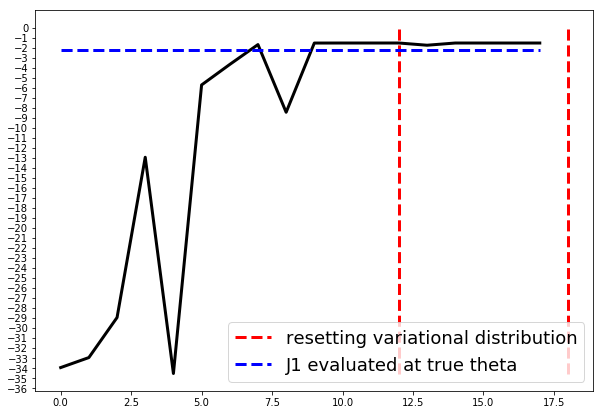

In [16]:
if optimise_scaling_param_separately:
    fig, ax = optimiser.plot_loss_curve(J1s_scale, true_theta = true_W.reshape(-1), X=X)

In [17]:
%%time
if optimise_scaling_param_separately:
    thetas_after_EM_step, J1s, J1_grads = optimiser.fit_using_analytic_q(other_param_inds, 
                                                                     X, 
                                                                     theta0=model.theta,
                                                                      disp=True,
                                                                     stop_threshold=stop_threshold, 
                                                                     max_num_em_steps=max_num_em_steps,
                                                                     gtol=gtol, 
                                                                     ftol=ftol, 
                                                                     plot=False)
    latent_nce_estimate = model.theta

CPU times: user 2.24 s, sys: 661 ms, total: 2.9 s
Wall time: 2.89 s


In [18]:
%%time
if not optimise_scaling_param_separately:
    thetas_after_EM_step, J1s, J1_grads = optimiser.fit_using_analytic_q(all_inds, 
                                                                         X, 
                                                                         theta0=theta0.reshape(-1),
                                                                          disp=True,
                                                                         stop_threshold=stop_threshold, 
                                                                         max_num_em_steps=max_num_em_steps,
                                                                         gtol=gtol, 
                                                                         ftol=ftol, 
                                                                         plot=False)
    latent_nce_estimate = model.theta

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 12.4 µs


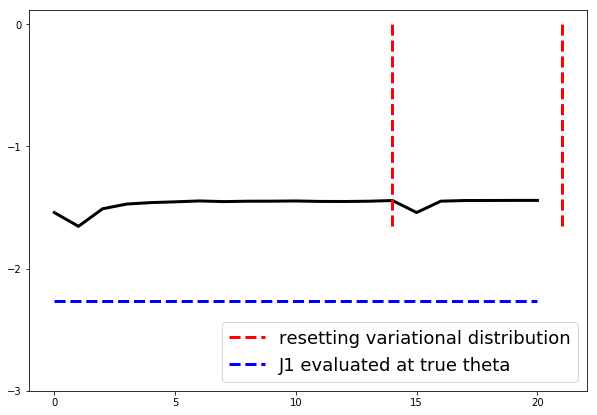

In [19]:
fig, ax = optimiser.plot_loss_curve(J1s, true_theta = true_W.reshape(-1), X=X)

In [20]:
J1_len = sum([len(i) for i in J1s])
#fig, ax = optimiser.plot_loss_curve(J1s, endpoints=(5, J1_len), true_theta = true_W.reshape(-1), X=X)

In [21]:
%%time
thetas_after_each_minibatch = cd_optimiser.fit(X, theta0=theta0.reshape(-1), num_gibbs_steps=cd_num_steps,
                                               learning_rate=cd_learn_rate, batch_size=cd_batch_size)
cd_estimate =  cd_model.theta

CPU times: user 202 ms, sys: 16 ms, total: 218 ms
Wall time: 202 ms


# Results

## Log-likelihood on training set

### $ \mathbb{E}_{x \sim P_{data}} \log(P_{data}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{lnce}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{cd}(x))  $

In [22]:
true_dist_probs_of_true_data, _ = true_data_dist.normalised_and_marginalised_over_z(X)
latent_nce_probs_of_true_data, _ = model.normalised_and_marginalised_over_z(X)
cd_probs_of_true_data, _ = cd_model.normalised_and_marginalised_over_z(X)
random_probs_of_true_data, _ = random_init_model.normalised_and_marginalised_over_z(X)
print('True:       {} \nLatent NCE: {} \nCD:         {}\nRandom init:{} '.format(
    np.mean(np.log(true_dist_probs_of_true_data)), 
    np.mean(np.log(latent_nce_probs_of_true_data)),
    np.mean(np.log(cd_probs_of_true_data)),
    np.mean(np.log(random_probs_of_true_data))
))

True:       -32.18388900322356 
Latent NCE: -33.45047727844393 
CD:         -32.830279769640605
Random init:-34.66618610749807 


## Frobenius norm of true parameters minus model parameters

In [23]:
# NOTE: we exclude the scaling parameter in all comparisons

random_true_param_diff = (true_W - theta0).reshape(-1)[1:]
sq_diff_rand_true = np.dot(random_true_param_diff, random_true_param_diff)**0.5
nce_true_param_diff = (true_W.reshape(-1) - latent_nce_estimate)[1:]
sq_diff_nce_true = np.dot(nce_true_param_diff, nce_true_param_diff)**0.5
cd_true_param_diff = (true_W.reshape(-1) - cd_estimate)[1:]
sq_diff_cd_true = np.dot(cd_true_param_diff, cd_true_param_diff)**0.5
nce_cd_param_diff = (latent_nce_estimate - cd_estimate)[1:]
sq_diff_nce_cd = np.dot(nce_cd_param_diff, nce_cd_param_diff)**0.5
print('true vs latent nce:   {}'.format(sq_diff_nce_true))
print('true vs cd:           {}'.format(sq_diff_cd_true))
print('true vs random init:  {}'.format(sq_diff_rand_true))
print('nce vs cd:            {}'.format(sq_diff_nce_cd))

true vs latent nce:   4.613596174909166
true vs cd:           4.497789953239701
true vs random init:  5.10340497633291
nce vs cd:            0.6083060421695993


### Scaling parameter

In [24]:
print('Learnt Scaling param is:              {}'.format(latent_nce_estimate[0]))
print('Norm const of data distribution is:   {}'.format(-np.log(true_norm_const)))

Learnt Scaling param is:              -33.98491559641065
Norm const of data distribution is:   -39.61904651217381


In [25]:
model.reset_norm_const()
print('We hope that the normalisation constant of the learnt model is 1. In reality it is: {} '.format(
    np.log(model.norm_const)))

We hope that the normalisation constant of the learnt model is 1. In reality it is: 2.985612383706314 


## Visualisations of parameters

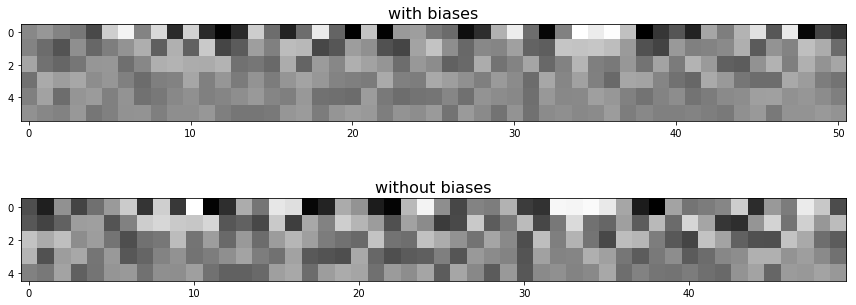

In [26]:
true_params = np.array(true_data_dist.theta.reshape(d+1, m+1).T)
true_params[0,0] = 0
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs = axs.ravel()
axs[0].imshow(true_params, cmap='gray')
axs[1].imshow(true_params[1:, 1:], cmap='gray')
axs[0].set_title('with biases', fontsize=16)
axs[1].set_title('without biases', fontsize=16)
#fig.suptitle('True parameters', fontsize=20)
plt.tight_layout()

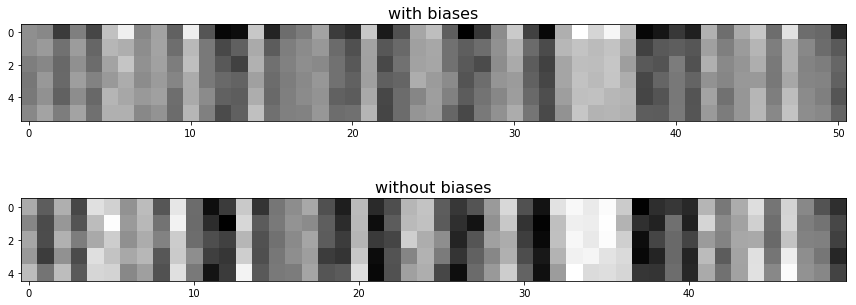

In [27]:
nce_params = np.array(model.theta.reshape(d+1, m+1).T)
nce_params[0,0] = 0
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs = axs.ravel()
axs[0].imshow(nce_params, cmap='gray')
axs[1].imshow(nce_params[1:, 1:], cmap='gray')
axs[0].set_title('with biases', fontsize=16)
axs[1].set_title('without biases', fontsize=16)
#fig.suptitle('True parameters', fontsize=20)
plt.tight_layout()

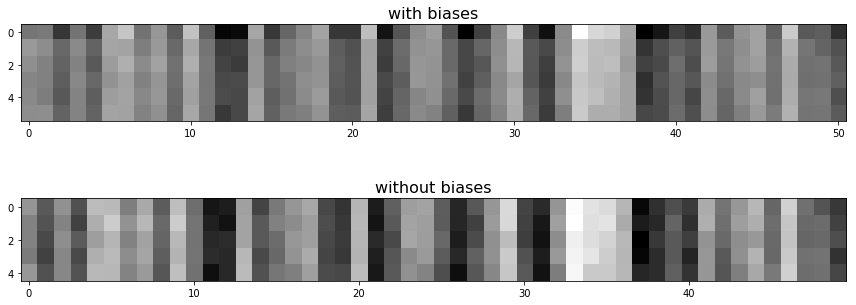

In [28]:
cd_params = np.array(cd_model.theta.reshape(d+1, m+1).T)
cd_params[0,0] = 0
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs = axs.ravel()
axs[0].imshow(cd_params, cmap='gray')
axs[1].imshow(cd_params[1:, 1:], cmap='gray')
axs[0].set_title('with biases', fontsize=16)
axs[1].set_title('without biases', fontsize=16)
#fig.suptitle('True parameters', fontsize=20)
plt.tight_layout()

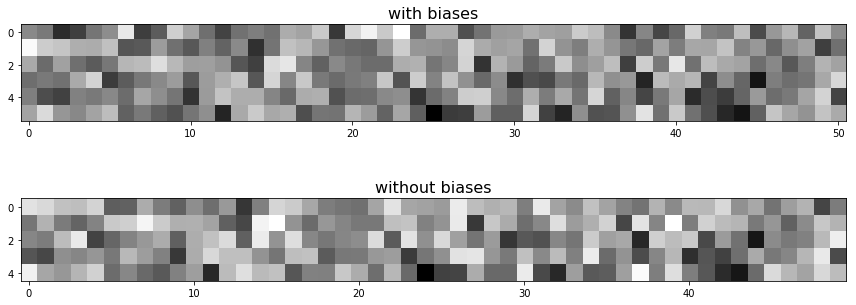

In [29]:
rnd_params = np.array(theta0.reshape(d+1, m+1).T)
rnd_params[0,0] = 0
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs = axs.ravel()
axs[0].imshow(rnd_params, cmap='gray')
axs[1].imshow(rnd_params[1:, 1:], cmap='gray')
axs[0].set_title('with biases', fontsize=16)
axs[1].set_title('without biases', fontsize=16)
#fig.suptitle('True parameters', fontsize=20)
plt.tight_layout()

In [30]:
# hidden biases
print('true hidden bias: {} \nnce hidden bias:  {} \ncd_hidden bias:   {}'.format(
    true_params[:,0], nce_params[:, 0], cd_params[:, 0]))

true hidden bias: [ 0.         -0.03628776  0.21595202 -0.1605034  -0.05665968  0.06777425] 
nce hidden bias:  [ 0.         -0.00118909 -0.02025479 -0.02840111 -0.02647846 -0.00812945] 
cd_hidden bias:   [0.         0.06422142 0.04676908 0.02909969 0.03656332 0.04318716]


In [31]:
# diff between nce & true visible biases
print(nce_params[0,:] - true_params[0,:])

[ 0.         -0.11838309 -0.07031706  0.09866757  0.36340497 -0.45138586
 -0.67399315  0.01445815 -0.56595157  0.61460289 -0.41843453  0.60853602
  0.80121794  0.52458228 -0.43513443  0.06563973  0.69737168  0.1708743
 -0.68684468  0.16252861  0.86417805 -0.36914696  0.8202942  -0.19784082
 -0.13821737  0.15900381  0.1460301   0.71008889  0.54229369 -0.30023079
 -0.66419628  0.09709014  0.78135779  0.08898661 -0.73424705 -0.64068536
 -0.72950216 -0.35439206  0.82490967  0.44885788  0.26537738  0.59816876
 -0.17662855  0.03263282 -0.27949222 -0.57740807  0.30952494 -0.60622476
  0.88833689  0.43754003  0.49519554]


In [32]:
# diff between nce & cd visible biases
print(nce_params[0,:] - cd_params[0,:])

[ 0.00000000e+00 -1.78628006e-02  1.04790379e-02 -1.83033142e-02
  1.38453794e-02 -3.03242666e-02 -2.67507054e-02 -7.35864689e-03
 -3.54428040e-02 -1.07606473e-02 -2.34506706e-02 -3.30085185e-02
  3.41358812e-02  3.41871165e-02 -2.08223589e-02 -1.75674542e-02
 -1.36379500e-02 -5.13520092e-02 -5.61512043e-02  1.10267950e-02
 -6.26524287e-03 -6.19894383e-02  3.23676599e-02 -1.75047557e-02
 -1.48731034e-02 -1.36406744e-02  8.07239032e-04  3.43870192e-02
 -1.27446088e-02 -3.81684279e-02 -8.56431205e-02 -1.03837686e-04
  1.63188565e-02  1.13296048e-03 -1.11350063e-01 -9.10763299e-02
 -4.03797630e-02 -3.44581072e-02  4.59958840e-02  2.46696343e-02
 -9.23470042e-03 -9.87598955e-03 -2.30379443e-02  6.13870583e-03
 -2.24282554e-02 -1.28076411e-02 -7.08068251e-03 -5.35596403e-02
  7.15057532e-03 -4.96698520e-03  2.29758847e-03]


# Validation of synthetic dataset

In [33]:
"""all_visibles = true_data_dist.get_all_binary_vectors(d)
visible_probs, true_dist_norm_const = true_data_dist.normalised_and_marginalised_over_z(all_visibles)
print('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(visible_probs)))

print('-------------------------Visible probability checks--------------------------------------')
for i in range(2**d):
    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_visibles[i], 
                                                                         freq, visible_probs[i]))
print('normalisation constant is: {}'.format(true_dist_norm_const))

all_hiddens = true_data_dist.get_all_binary_vectors(m)
hidden_probs, _ = true_data_dist.normalised_and_marginalised_over_u(all_hiddens)

print('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(hidden_probs)))

var_dist.alpha = true_W.reshape(-1)
Z_from_posterior_class = var_dist.sample(1000, X)

print('-------------------------Hidden probability checks--------------------------------------')
for i in range(2**m):
    freq = np.mean(np.product((Z_from_posterior_class == all_hiddens[i]), axis=(-1)))
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_hiddens[i], 
                                                                         freq, hidden_probs[i]))"""

"all_visibles = true_data_dist.get_all_binary_vectors(d)\nvisible_probs, true_dist_norm_const = true_data_dist.normalised_and_marginalised_over_z(all_visibles)\nprint('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(visible_probs)))\n\nprint('-------------------------Visible probability checks--------------------------------------')\nfor i in range(2**d):\n    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)\n    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_visibles[i], \n                                                                         freq, visible_probs[i]))\nprint('normalisation constant is: {}'.format(true_dist_norm_const))\n\nall_hiddens = true_data_dist.get_all_binary_vectors(m)\nhidden_probs, _ = true_data_dist.normalised_and_marginalised_over_u(all_hiddens)\n\nprint('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(hidden_probs)))\n\nvar_dist.alpha = true_W.reshape(-1)\nZ_fr